In [1]:
'''
Licensed Materials - Property of IBM
IBM Maximo APM - Predictive Maintenance Insights On-Premises
IBM Maximo APM - Predictive Maintenance Insights SaaS 
IBM Maximo Application Suite
© Copyright IBM Corp. 2019,2020,2021 All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.
'''

'\nLicensed Materials - Property of IBM\nIBM Maximo APM - Predictive Maintenance Insights On-Premises\nIBM Maximo APM - Predictive Maintenance Insights SaaS \nIBM Maximo Application Suite\n© Copyright IBM Corp. 2019,2020,2021 All Rights Reserved.\nUS Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.\n'

# Maximo Predict - Failure Probability Binary Classification Model Template

1. [Introduction](#introduction)
2. [Install Maximo Predict SDK](#install-maximo-apm-pmi-sdk)
3. [Setup the Model Training Pipeline](#setup-model-training-pipline)
4. [Train the Model Instance](#train-model-instance)
5. [Register the Trained Model Instance](#register-trained-model-instance)
6. [Model Template Internals](#model-template-internals)

<a id='introduction'></a>
## Introduction

In this notebook, we will be predicting imminent failures for assets using IoT sensor data and past failure history data. Our goal is to build models that can characterize the probability that a given asset with fail within a given future prediction window. We will perform the prediction for 15, 30 and 60 days. The temporal granularity of the prediction window can be tuned as required.

This data are derived from an actual oil-platform but the field names have been anonymized. We'll be building failure prediction models for a particular asset type _**Pumps**_. In the following image, a time series of sensor data is generated where we consider the recent sensor data history for a predefined interval and extract features from it. We also look ahead into the future for a fixed window to generate the target labels. The idea is to build a machine learning pipeline which characterizes the "pre-failure signal" from the extracted features.

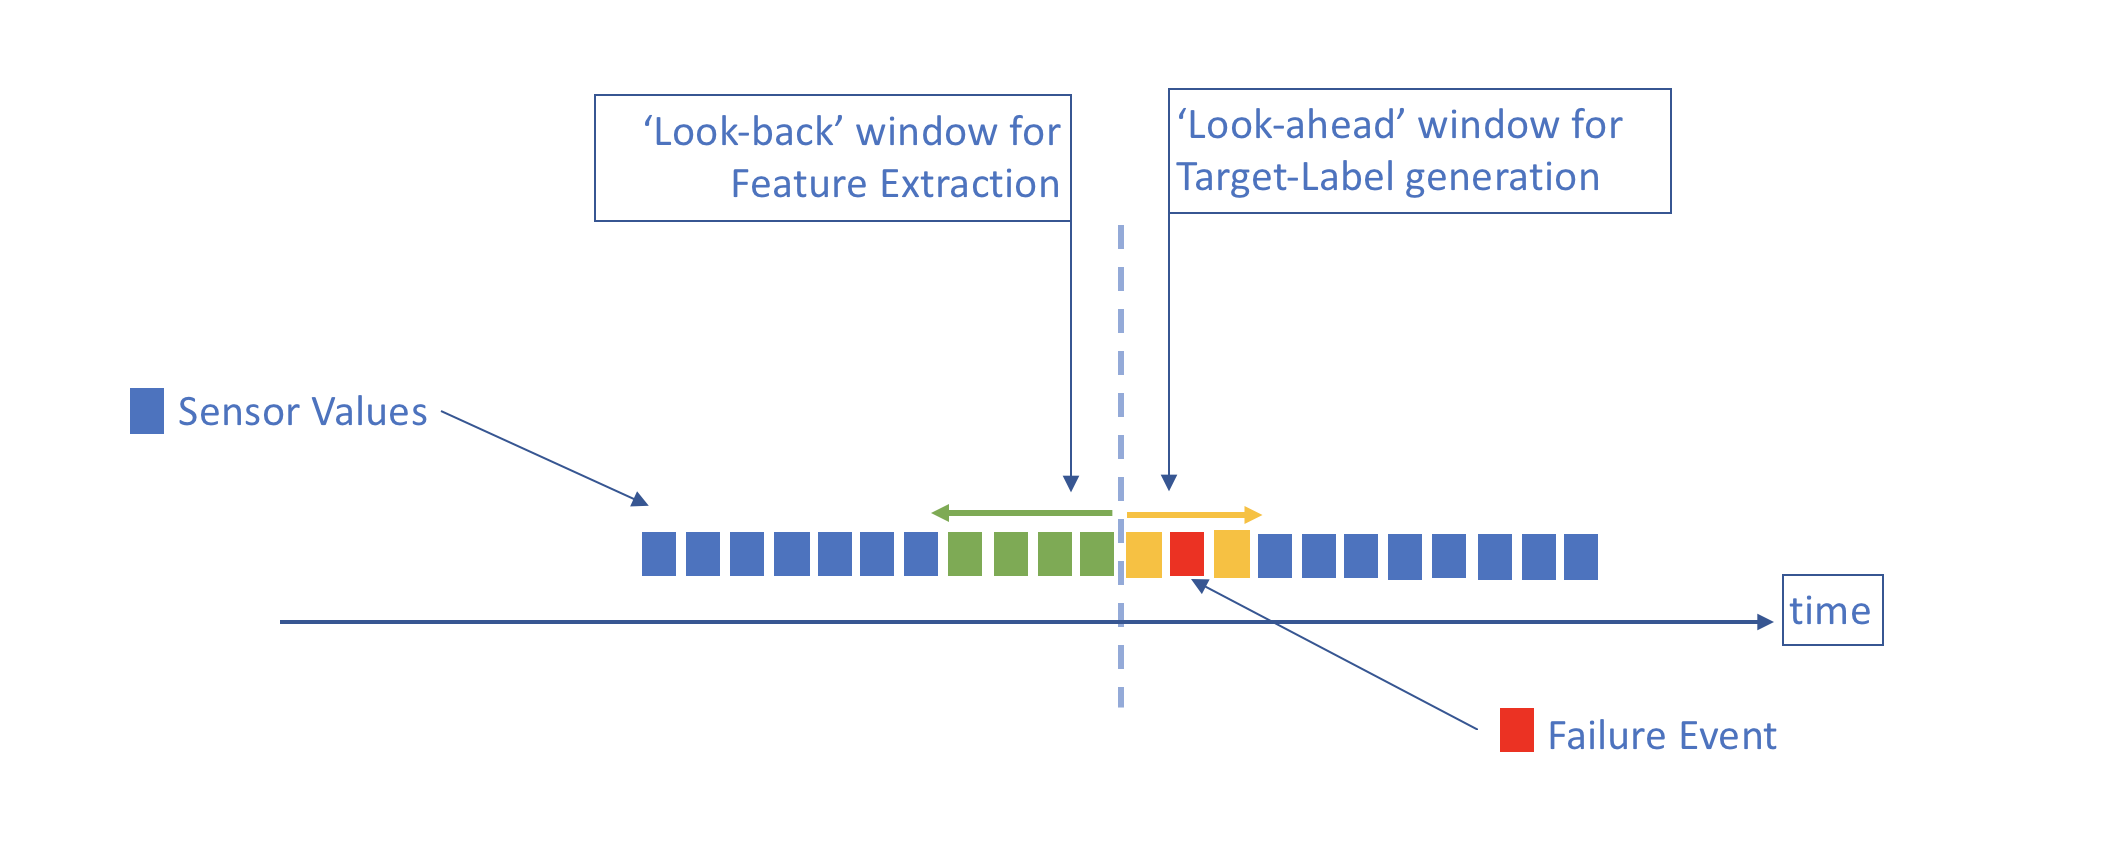

<a id="install-maximo-apm-pmi-sdk"></a>
## Install Maximo Predict SDK

You will need follow 3 credentials to run the notebook. You can obtain them if you are admin on Maximo Predict UI.
             APM_ID: Application Administration -> System Properties -> Filter -> Search PMIId -> Current Value (eg. b95ed774)
             APM_API_BASEURL: Application Administration -> Integration -> End Points--> Searh for predict -> click search result PREDICTAPI -> URL (e.g https://predict-api.mas-pmidev1-predict.svc, note you just need first part of the url)
             APM_API_KEY: Application Administration -> Go To Administration -> Copy key from user card (e.g. 6805t46gn3tef37pu0picpg9vcq3hsmamm1enc), or Add API key if not exist.

In [26]:
import logging
logger_pyspark = logging.getLogger('pyspark').setLevel(logging.ERROR)
logger_py4j = logging.getLogger('py4j').setLevel(logging.ERROR)
logger_py4java = logging.getLogger('py4j.java_gateway').setLevel(logging.ERROR)

In [3]:
# This cell loads the json mediated integration between related notebooks. For this group the json is called 'fast_execution.json'
#
# This section adds the current notebook to the json and warns if precursors do not have outputs registered indicating they have not been run
# 

import json
from project_lib import Project
project = Project.access()
store = json.load(project.get_file("fast_execution.json"))
store
notebook_name = "PMI - Failure Probability-Binary Classification"
notebook_precursors = ["FastStartLoader-Predict"]
store[notebook_name] = {"precursors":notebook_precursors, "outputs":{}}
store_json = json.dumps(store, indent =4)
project.save_data("fast_execution.json", store_json, overwrite=True)
print("Notebook added to json")
for precursor in notebook_precursors:
    for nb in store:
        if precursor == nb:
            #Found precursor. Check if it has output(meaning it has been run)
            if store[precursor]["outputs"] == {}:
                #Precursor has not been run. Must run before notebook can be run
                raise ValueError(precursor + " must run before this notebook.")
                
# This loads the variables generated by the precursor notebooks needed to run the current notebook.
                
asset_group_id = store["FastStartLoader-Predict"]["outputs"]["asset_group_id"]
device_type=store["FastStartLoader-Predict"]["outputs"]["device_type"]
print('asset_group_id='+asset_group_id)
print('device_type='+device_type)

Notebook added to json
asset_group_id=1007
device_type=Pump_EUDEMO_ST


In [4]:
!pip uninstall -y pmlib

In [27]:
# Predict_Envs.json is a data file containing the variables needed to run services and access resources from within notebooks.
#
# It must be populated by the user and instructions are contained within it.



import os
# Opening JSON file
f = open('/project_data/data_asset/Predict_Envs.json',)
data = json.load(f)
f.close()
os.environ['APM_ID'] = data['APM_ID']
os.environ['APM_API_BASEURL'] = data['APM_API_BASEURL']
os.environ['APM_API_KEY'] = data['APM_API_KEY']



In [28]:
# Overwrite access credentials if needed
# %%capture
# # @hidden_cell
# %env APM_ID=*************
# %env APM_API_BASEURL=https://*************
# %env APM_API_KEY=*************

In [29]:
import os
os.environ['TRUST_PREDICT']= os.getenv('APM_API_BASEURL')[8:]
print(os.getenv('TRUST_PREDICT'))

maslab-predict-api.mas-maslab-predict.svc


In [8]:
# import os

# os.environ['SSL_VERIFY_APM'] = 'False'
# os.environ['SSL_VERIFY_AS'] = 'False'

# os.environ['REST_METADATA_URL']='https://main.api.monitor.test.ivt03.suite.maximo.com'
# os.environ['REST_KPI_URL']='https://main.api.monitor.test.ivt03.suite.maximo.com'

Then, install Maximo Predict SDK with `pip`.

In [30]:
!pip install sklearn-deap=='0.2.3'
!pip install --trusted-host ${TRUST_PREDICT}  -U ${APM_API_BASEURL}/ibm/pmi/service/rest/ds/${APM_ID}/${APM_API_KEY}/lib/download?filename=pmlib

     |████████████████████████████████| 189.3 MB 33.1 MB/s eta 0:00:01 0:00:04█████▋                     | 62.9 MB 38.2 MB/s eta 0:00:04  | 98.3 MB 29.2 MB/s eta 0:00:04��█████████████▊              | 105.1 MB 29.2 MB/s eta 0:00:03     |██████████████████▏             | 107.1 MB 29.2 MB/s eta 0:00:03     |█████████████████████▍          | 126.5 MB 35.7 MB/s eta 0:00:02127.9 MB 35.7 MB/s eta 0:00:02     |██████████████████████▌         | 133.1 MB 35.7 MB/s eta 0:00:02�████████████████████▌        | 139.1 MB 35.7 MB/s eta 0:00:02     |███████████████████████████▉    | 164.4 MB 34.4 MB/s eta 0:00:01     |██████████████████████████████▌ | 180.3 MB 34.4 MB/s eta 0:00:01
Processing //tmp/1000710000/pip-req-build-_i_083sg/dslib/srom-1.4.0rc7.1.0-cp38-cp38-linux_x86_64.whl
Processing //tmp/1000710000/pip-req-build-_i_083sg/dslib/dqlearn-0.4.2.1.0-cp38-cp38-linux_x86_64.whl
Processing //tmp/1000710000/pip-req-build-_i_083sg/dslib/aixclient.zip
dqlearn is already installed with the same version 

In [10]:
#required by DQLearn
#!pip install pmlib[dqlearn_plot]

In [31]:
#pyspark version needs to be 2.4.5 for the srom version being used.
import pkg_resources

dists = [d for d in pkg_resources.working_set]

if not('pyspark' in dists):
    print ("pyspark does not exist. Installing ..." )
    !pip install pyspark==3.0.1
else:
    print ("pyspark already exists. Not installing")

pyspark does not exist. Installing ...


In [12]:
!pip install graphviz
!pip install pwlf

In [32]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib

<a id="setup-model-training-pipline"></a>
## Setup the Model Training Pipeline

Before you can start working on the model training pipeline, you have to setup an asset group and asset-sensor relationshp properly in Maximo. See IBM Maximo APM - Predictive MaintenanceInsights SaaS User Guide for details.

Required model pipeline configuration:

* Asset group ID: The unit of model processing is an asset group. Asset groups are managed on Maximo APM UI. You need to get the ID of the asset group to be analyzed by this model.
* Asset failure history as the label: This model requires asset failure history (Asset Workorder attribute **```faildate```** in Maximo) to extract the label for training.
* Sensor data as features: This model also accepts one or more features from either asset data or IOT data. **Note that these features must be of numeric type.** Features are specifed simply by attribute names prefixed by type (with separator colon). For asset attribute, the prefix is an empty string. For IOT data attribute, the prefix is the device type registered on Watson IOT Platform.
* Prediction output names: This model generates two outputs, the predicted failure failure probability and the root cause analysis decision tree path. Give them names (containing only alphanumeric, dash, and underline). **Note that the order of the two names matters, the first must be the predicted failure probability.**
* Aggregation methods: The features to this model are generated from the sensor data by finding rolling averages over a fixed window size for the entire dataset. Since we want to use the previous N days sensor data to predict whether a failure event is going to take place in the future, we use a "look-back" window of N days. We can use different aggregation methods like mean, maximum, minimum, median, standard deviation, sum, count for computing the rolling values. If it is not given, the default uses **```['mean', 'max', 'min', 'median', 'std', 'sum', 'count']```**.
* Prediction window size: This model can compute the probability of asset failure within a given future prediction window. The prediction window is specified in [Pandas offset alias](http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). Examples: "```15d```" for 15 days, "```30d```" for 30 days.

Now you can setup a training pipeine based on this model template, with your own data, to train a model instance.

In [33]:
import pmlib

In [34]:

iot_type=device_type
desired_features = ['VELOCITYX','VELOCITYY','VELOCITYZ']
device_type_qualified_features = [device_type+':'+col for col in desired_features]
print(device_type_qualified_features)

['Pump_EUDEMO_ST:VELOCITYX', 'Pump_EUDEMO_ST:VELOCITYY', 'Pump_EUDEMO_ST:VELOCITYZ']


In [16]:
# from pmlib.failure_prediction import FailurePredictionAssetGroupPipeline

# group = FailurePredictionAssetGroupPipeline(
#             asset_group_id=asset_group_id, 
#             model_pipeline={
#                 #"features": ["SampleFailureSensor:sensor_1", "SampleFailureSensor:sensor_2", "SampleFailureSensor:sensor_3"],
#                 "features" : device_type_qualified_features,
#                 'features_resampled': {
#                         iot_type: {
#                             '${freqency}': '1D',
#                             'VELOCITYX': {
#                                 'mean': None,
#                             },
#                             'VELOCITYY': {
#                                 'mean': None,
#                             },
#                             'VELOCITYZ': {
#                                 'mean': None,
#                             },
#                         },
#                     },
#                 "predictions": ["failure_probability", "rca_path"],
#                 #"aggregation_methods": ["mean", "max", "min", "median", "std", "sum", "count"],
#                 "aggregation_methods": ["max", "min"],
#                 "prediction_window_size": "3d",
#                 "execution_type":'spark_node_random_search',
#                 'max_evaluation_time': 10,
#             })


The example above configured a pipeline for this model, accepting **```axlevibration``` and **```axlemomentum```** of Watson IOT Platform device type **```TrainBrakeSensor```**. It also uses asset attribute **```faildate```** to extract the labels for training. The predicted output of the trained model instance is called **```failure_probability_1d```** (for predicted probability) and **```rca_path_1d```** (for root cause analysis decision tree path). The pipeline is also configured with a preprocessing stage generating aggregation metrics: mean, max, min, median, std, sum, and count, as extra features to the model. Finally, this pipeline is configured to predict for the future 1 day.

By default, this model also generated daily and group daily aggregated prediction result taking output names in the form of **```daily_<failure_probability_output_name>```** and **```group_daily_<failure_probability_output_name>```**.

<a id="train-model-instance"></a>
## Train the Model Instance

Now you can train the model instance.

In [17]:
# %time df = group.execute()
#df = group.execute(start_ts='2010-01-01',end_ts='2021-12-31')

<a id="register-trained-model-instance"></a>
## Register the Trained Model Instance

In [18]:
# group.register()

In [19]:
# All time is UTC time, see following examples to set schedule to run every 5 minute, every hour, every day, every week, every month
# minute and second will be ignored. "2021-04-12 15:12:15" is same as "2021-04-12 15:00:00" in following examples
#group.enable(enabled=True, schedule={"starting_at": "2021-04-09 15:35:15", "every": "5min"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1H"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1D"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1W"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1M"})

#group.enable(enabled=True,schedule={"starting_at": "05:00:01", "every": "5min"},backtrack={"days":20})
# group.enable(enabled=True,schedule={"starting_at": "05:00:01", "every": "5min"})

# How to Custom the Model

You can override the "override_training_stages" to custom the algorithm used in the model training.

In [38]:
from srom.feature_engineering.model_based_feature_generator import ModelbasedFeatureGenerator
import os
import time
import warnings
import uuid
import numpy as np
from operator import itemgetter
from multiprocessing import cpu_count

from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.naive_bayes import (BernoulliNB, GaussianNB, MultinomialNB)
from sklearn.kernel_approximation import RBFSampler, AdditiveChi2Sampler, Nystroem, SkewedChi2Sampler
from sklearn.cluster import KMeans, FeatureAgglomeration

from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import (LogisticRegression, PassiveAggressiveClassifier,
                                  SGDClassifier, RidgeClassifier, Perceptron)
 
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import (LinearSVC, NuSVC, SVC)
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, Normalizer
from srom.pipeline.srom_param_grid import SROMParamGrid
from srom.pipeline.srom_pipeline import SROMPipeline
from srom.utils.no_op import NoOp
from srom.feature_engineering.model_based_feature_generator import ModelbasedFeatureGenerator
from sklearn.feature_selection import VarianceThreshold
from srom.feature_selection.variance_based_feature_selection import LowVarianceFeatureElimination
from srom.auto.base_auto import SROMAutoPipeline
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding, TSNE
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import KBinsDiscretizer, PowerTransformer

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA, FactorAnalysis, FastICA, IncrementalPCA, KernelPCA, NMF, SparsePCA, TruncatedSVD
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer

from srom.pipeline.hyper_params.classification_fine_grid_for_bayesian import PARAM_GRID as bayesian_paramgrid
from srom.pipeline.hyper_params.classification_sample_grid_for_rbfopt import PARAM_GRID as rbopt_paramgrid
from sklearn.calibration import CalibratedClassifierCV

In [37]:
feature_transformation_set = [('skiptransformation', NoOp()),('normalizer', Normalizer())]

scaler_set = [('skipscaling', NoOp()),('standardscaler', StandardScaler()),('minmaxscaler', MinMaxScaler())]

feature_preprocessing_set = [('skipfeaturepreprocessing', NoOp()),('pca', PCA()), ('fastica', FastICA()), ('kernelpca', KernelPCA()), ('selectkbest', SelectKBest()), ('variancethreshold', VarianceThreshold())]

estimator_feature_generator = [('skipmodelfeaturegeneration', NoOp()),('multinomialnbfeature', ModelbasedFeatureGenerator(MultinomialNB())),\
                                                          ('decisiontreeclassifierfeature', ModelbasedFeatureGenerator(DecisionTreeClassifier())), ('extratreesclassifierfeature', ModelbasedFeatureGenerator(ExtraTreesClassifier())), \
                                                          ('randomforestclassifierfeature', ModelbasedFeatureGenerator(RandomForestClassifier()))]

'''
estimator_set = [
                ('randomforestclassifier', RandomForestClassifier())
                ]
'''


estimator_set = [
    #('randomforestclassifier', RandomForestClassifier())
    ('xgboost', XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27))
]

my_stage = [feature_transformation_set,
                       scaler_set,
                       feature_preprocessing_set,
                       estimator_feature_generator,
                       estimator_set]

print(my_stage)

[[('skiptransformation', NoOp()), ('normalizer', Normalizer())], [('skipscaling', NoOp()), ('standardscaler', StandardScaler()), ('minmaxscaler', MinMaxScaler())], [('skipfeaturepreprocessing', NoOp()), ('pca', PCA()), ('fastica', FastICA()), ('kernelpca', KernelPCA()), ('selectkbest', SelectKBest()), ('variancethreshold', VarianceThreshold())], [('skipmodelfeaturegeneration', NoOp()), ('multinomialnbfeature', ModelbasedFeatureGenerator(estimator=MultinomialNB())), ('decisiontreeclassifierfeature', ModelbasedFeatureGenerator(estimator=DecisionTreeClassifier())), ('extratreesclassifierfeature', ModelbasedFeatureGenerator(estimator=ExtraTreesClassifier())), ('randomforestclassifierfeature', ModelbasedFeatureGenerator(estimator=RandomForestClassifier()))], [('xgboost', XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
     

In [22]:
# feature_transformation_set = [('skiptransformation', NoOp()),('normalizer', Normalizer())]

# scaler_set = [('skipscaling', NoOp()),('standardscaler', StandardScaler()),('minmaxscaler', MinMaxScaler())]

# feature_preprocessing_set = [('skipfeaturepreprocessing', NoOp()),('pca', PCA()), ('fastica', FastICA()), ('kernelpca', KernelPCA()), ('selectkbest', SelectKBest()), ('variancethreshold', VarianceThreshold())]

# estimator_feature_generator = [('skipmodelfeaturegeneration', NoOp()),('multinomialnbfeature', ModelbasedFeatureGenerator(MultinomialNB())),\
#                                                           ('decisiontreeclassifierfeature', ModelbasedFeatureGenerator(DecisionTreeClassifier())), ('extratreesclassifierfeature', ModelbasedFeatureGenerator(ExtraTreesClassifier())), \
#                                                           ('randomforestclassifierfeature', ModelbasedFeatureGenerator(RandomForestClassifier()))]




    

# estimator_set = [

           

#             ('CalibratedClassifierCV', CalibratedClassifierCV ( SGDClassifier()))

           

#                     ]

# my_stage = [feature_transformation_set,

#                        scaler_set,

#                        feature_preprocessing_set,

#                        estimator_feature_generator,

#                        estimator_set]

# print(my_stage)

In [49]:
from pmlib.failure_prediction import FailurePredictionAssetGroupPipeline

group = FailurePredictionAssetGroupPipeline(
            asset_group_id=asset_group_id, 
            model_pipeline={
                "features": device_type_qualified_features,
                'features_resampled': {
                iot_type: {
                    '${freqency}': '1D',
                    'VELOCITYX': {
                    'mean': None,
                    },
                    'VELOCITYY': {
                    'mean': None,
                    },
                    'VELOCITYZ': {
                    'mean': None,
                    },
                    },
                },
                #"features" : ['TrainBrakeSensor:axlevibration', 'TrainBrakeSensor:axlemomentum'],
                "predictions": ["failure_probability", "rca_path"],
                "aggregation_methods": ["mean", "max", "min"],  #["mean", "max", "min", "median", "std", "sum", "count"],
                "prediction_window_size": "9d",
                "override_training_stages": my_stage,
            })

2022-07-13T18:43:41.602 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.__init__ DEBUG in __init__ of AssetGroupPipeline, call api.init_environ()
2022-07-13T18:43:41.606 pmlib.api._get_db INFO db2
2022-07-13T18:43:41.608 pmlib.api._get_db INFO db2
2022-07-13T18:43:41.609 pmlib.api._get_db INFO DATABASE=BLUDB;HOSTNAME=c-db2wh-iot-db2u-engn-svc.db2u.svc;PORT=50001;PROTOCOL=TCPIP;UID=db2inst1;PWD=DkJ1KUNjxKsjXi8;SECURITY=SSL;SSLServerCertificate=/project_data/data_asset/db2_certificate.pem
2022-07-13T18:43:41.860 iotfunctions.dbtables._store_table_exists DEBUG Table "SKOLAB_MAM"."KPI_MODEL_STORE" exists.
2022-07-13T18:43:41.861 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-13T18:43:41.861 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-13T18:43:41.862 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE

In [50]:
#df = group.execute(start_ts='2008-01-01',end_ts='2009-12-31')
#df = group.execute(start_ts='2018-01-01',end_ts='2019-12-31')
%time df = group.execute()

2022-07-13T18:44:13.099 pmlib.api._validate_resampling DEBUG start of _validate_resampling entity_type_name=Pump_EUDEMO_ST
2022-07-13T18:44:13.102 pmlib.api._get_db INFO db2
2022-07-13T18:44:13.103 pmlib.api._get_db INFO db2
2022-07-13T18:44:13.104 pmlib.api._get_db INFO DATABASE=BLUDB;HOSTNAME=c-db2wh-iot-db2u-engn-svc.db2u.svc;PORT=50001;PROTOCOL=TCPIP;UID=db2inst1;PWD=DkJ1KUNjxKsjXi8;SECURITY=SSL;SSLServerCertificate=/project_data/data_asset/db2_certificate.pem
2022-07-13T18:44:15.960 iotfunctions.dbtables._store_table_exists DEBUG Table "SKOLAB_MAM"."KPI_MODEL_STORE" exists.
2022-07-13T18:44:15.962 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-13T18:44:15.964 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-13T18:44:15.965 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE: db2
2022-07-13T18:44:15.969 iotfun

Flow                  Layer                             Validator  \
0   sensor_table  sensor_table__layer_1           timestamp_col_format_verify   
1                                                    sensor_col_format_verify   
2                 sensor_table__layer_2                  missing_ratio_column   
3                                                       infinity_ratio_column   
4                                                           zero_ratio_column   
5                                                            constant_columns   
6                                                              duplicate_rows   
7                                                        check_no_categorical   
8                 sensor_table__layer_3  check_gaussian_distribution_multicol   
9                                                           outlier_detection   
10                sensor_table__layer_4                           asset_count   
11                                             assets_have_same_sampling_freq   

    Score Issue Detected Status  Time (sec)  
0     0.0            Yes   fail        0.00  
1     1.0                  pass        0.00  
2     1.0                  pass        0.01  
3     1.0                  pass        0.01  
4     1.0                  pass        0.00  
5     1.0                  pass        0.00  
6     1.0                  pass        0.01  
7     1.0                  pass        0.00  
8     0.0            Yes   fail        0.01  
9     1.0                  pass        1.26  
10    0.5            Yes   fail        0.00  
11    0.0            Yes   fail        0.03



Recommendation:
--------------
1. The corect format is important for processing timeseries data.
2. The corect format is important for processing timeseries data.
3. There seems to be no issues in the data
4. There are no issues detected in the data.
5. Having large number of zeros in the data (specially numerical columns)can mean there are data quality issues existing in the data and that may need correction.
6. Columns can have only 1 value in all the rows. (for eg. the entire column is 1 etc.).This column signals redundancy in the data and can be removed.
7. There are no issues detected in the data.
8. There are no issues detected in the data.
9. The values of feature does not look Gaussian.
10. No explanation.
11. The number of asset in the data is 5 which is less than default 10.
12. The number of frequencies present in your time stamp column is more than 1. Cannot run this data through Failure Prediction Analysis Notebook unless frequencies are constant.
2022-07-13T18:44:47.725

# Report

#### <span style="color:#3ba783">Checks Passed:</span> <span style="color:black">1/2</span>

#### <span style="color:#3ba783">Results from Individual checks:</span> <span style="color:black">


<table border="0" >
<col width="200"> 
<col width="150"> 
 <tr>    
    <td style="text-align: center"><b>Check</></td>
    <td style="text-align: center"><b>Status</></td>
 </tr>
 <tr>    
    <td><b>Date Column Format</></td>
    <td style="color:red; text-align: center;">FAILED</td>
 </tr>
 <tr>    
    <td><b>Sensor Column Format</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
</table>

---

# Date Column Format


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies whether the "date_column" format is integer or datetime. A score of 1 indicates the correct format.</td>
    <td style="text-align: center; vertical-align: center; color:red">FAILED</td>
    <td style="text-align: center; vertical-align: center;">0</td>
    <td style="text-align: left;">The corect format is important for processing timeseries data.</td>
 </tr>
</table>

---

# Sensor Column Format


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies if the "date_column" format is integer or datetime. A score of 1 indicates the correct format.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1</td>
    <td style="text-align: left;">The corect format is important for processing timeseries data.</td>
 </tr>
</table>

---

# Report

#### <span style="color:#3ba783">Checks Passed:</span> <span style="color:black">6/6</span>

#### <span style="color:#3ba783">Results from Individual checks:</span> <span style="color:black">


<table border="0" >
<col width="200"> 
<col width="150"> 
 <tr>    
    <td style="text-align: center"><b>Check</></td>
    <td style="text-align: center"><b>Status</></td>
 </tr>
 <tr>    
    <td><b>Missing Value in Columns</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
 <tr>    
    <td><b>Infinity Value in Columns</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
 <tr>    
    <td><b>Zeros Count in Numerical Columns</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
 <tr>    
    <td><b>Columns with Constant Values</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
 <tr>    
    <td><b>Duplicate Rows in all Columns</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
 <tr>    
    <td><b>Categorical values in Numeric Columns</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
</table>

---

# Missing Value in Columns


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies the ratio of missing values in each column in the dataset.
A score of 1 indicates no missing values in the data.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">There seems to be no issues in the data</td>
 </tr>
</table>

---

# Infinity Value in Columns


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Finds the percentage of occurrence of infinity in all columns.
The score of 1 indicates no infinity values in the data.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">There are no issues detected in the data.</td>
 </tr>
</table>

---

# Zeros Count in Numerical Columns


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Finds the ratio of zero in all columns.
A score of 1 indicates that none of the columns are completely filled with zeros.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">Having large number of zeros in the data (specially numerical columns)can mean there are data quality issues existing in the data and that may need correction.</td>
 </tr>
</table>

---

# Columns with Constant Values


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies columns having constant value of the provided DataFrame.
A score of 1 indicated that none of the columns are filled with a single constant value.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">Columns can have only 1 value in all the rows. (for eg. the entire column is 1 etc.).This column signals redundancy in the data and can be removed.</td>
 </tr>
</table>

---

# Duplicate Rows in all Columns


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies if the rows in selected columns (by default, all columns) are same.
A score of 1 indicates that there are no duplicate rows.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">There are no issues detected in the data.</td>
 </tr>
</table>

---

# Categorical values in Numeric Columns


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies if no categorical columns are there in numeric columns.
A score of 1 indicates that no categorical columns exist when numerical columns were expected.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">There are no issues detected in the data.</td>
 </tr>
</table>

---

# Report

#### <span style="color:#3ba783">Checks Passed:</span> <span style="color:black">1/2</span>

#### <span style="color:#3ba783">Results from Individual checks:</span> <span style="color:black">


<table border="0" >
<col width="200"> 
<col width="150"> 
 <tr>    
    <td style="text-align: center"><b>Check</></td>
    <td style="text-align: center"><b>Status</></td>
 </tr>
 <tr>    
    <td><b>Gaussian Distribution</></td>
    <td style="color:red; text-align: center;">FAILED</td>
 </tr>
 <tr>    
    <td><b>Find Outliers in Timeseries Values</></td>
    <td style="color:green; text-align: center;">PASSED</td>
 </tr>
</table>

---

# Gaussian Distribution


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Finds if a random variable has Gussian distribution or not (a feature from dataframe) - In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some
suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.</td>
    <td style="text-align: center; vertical-align: center; color:red">FAILED</td>
    <td style="text-align: center; vertical-align: center;">8.409358551513554e-15</td>
    <td style="text-align: left;">The values of feature does not look Gaussian.</td>
 </tr>
</table>

---

# Find Outliers in Timeseries Values


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Identifies the outlier in the timeseries data. A score of 1 indicates no outliers present in the data.</td>
    <td style="text-align: center; vertical-align: center; color:green">PASSED</td>
    <td style="text-align: center; vertical-align: center;">1.0</td>
    <td style="text-align: left;">No explanation.</td>
 </tr>
</table>

---

# Report

#### <span style="color:#3ba783">Checks Passed:</span> <span style="color:black">0/2</span>

#### <span style="color:#3ba783">Results from Individual checks:</span> <span style="color:black">


<table border="0" >
<col width="200"> 
<col width="150"> 
 <tr>    
    <td style="text-align: center"><b>Check</></td>
    <td style="text-align: center"><b>Status</></td>
 </tr>
 <tr>    
    <td><b>Unique Assets in Data</></td>
    <td style="color:red; text-align: center;">FAILED</td>
 </tr>
 <tr>    
    <td><b>Frequencies in Grouped Data</></td>
    <td style="color:red; text-align: center;">FAILED</td>
 </tr>
</table>

---

# Unique Assets in Data


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">Find the total unique assets using the asset id count.
A score of 1 indicates that the unique asset count is greater than `min_asset_count` parameter.</td>
    <td style="text-align: center; vertical-align: center; color:red">FAILED</td>
    <td style="text-align: center; vertical-align: center;">0.5</td>
    <td style="text-align: left;">The number of asset in the data is 5 which is less than default 10.</td>
 </tr>
</table>

---

# Frequencies in Grouped Data


<table border="1" >
<col width="500"> 
<col width="150"> 
<col width="150"> 
<col width="500"> 
 <tr>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Description</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Status</></td>
    <td style="text-align: center; vertical-align: center; color:#3ba783"><b style="font-size:24px">Score</></td>
    <td style="text-align: left; vertical-align: center; color:#3ba783"><b style="font-size:24px">Recommendation</></td>
 </tr>
 <tr>
    <td style="text-align: left">For any data with time series column and a grouping column, finds all the
frequency of data. </td>
    <td style="text-align: center; vertical-align: center; color:red">FAILED</td>
    <td style="text-align: center; vertical-align: center;">0.0</td>
    <td style="text-align: left;">The number of frequencies present in your time stamp column is more than 1. Cannot run this data through Failure Prediction Analysis Notebook unless frequencies are constant.</td>
 </tr>
</table>

---

2022-07-13T18:44:49.171 pmlib.failure_prediction.DataQualityAdvisor.execute DEBUG In DataQualityAdvisor failure_table=
shape=(214, 16), 
index={0: 'int64'}, 
columns={'id': 'O', 'evt_timestamp': '<M8[ns]', 'VELOCITYX': 'float64', 'VELOCITYY': 'float64', 'VELOCITYZ': 'float64', 'VELOCITYX__mean__9d': 'float64', 'VELOCITYY__mean__9d': 'float64', 'VELOCITYZ__mean__9d': 'float64', 'VELOCITYX__max__9d': 'float64', 'VELOCITYY__max__9d': 'float64', 'VELOCITYZ__max__9d': 'float64', 'VELOCITYX__min__9d': 'float64', 'VELOCITYY__min__9d': 'float64', 'VELOCITYZ__min__9d': 'float64', 'datetime': '<M8[ns]', 'faildate': 'int64'}, head(5)=
                       id evt_timestamp  VELOCITYX  VELOCITYY  VELOCITYZ  \
0  ST_1393137-____-EUDEMO    2021-12-16   0.161602   0.162282   0.162463   
1  ST_1393137-____-EUDEMO    2021-12-17   0.167051   0.167626   0.167846   
2  ST_1393137-____-EUDEMO    2021-12-18   0.172364   0.173734   0.173542   
3  ST_1393137-____-EUDEMO    2021-12-19   0.177987   0.179089   

Flow                   Layer                    Validator  Score  \
0  failure_table  failure_table__layer_1  timestamp_col_format_verify    1.0   
1                                              failure_id_categorical    1.0   
2                 failure_table__layer_2         missing_ratio_column    1.0   
3                                                      duplicate_rows    1.0   
4                 failure_table__layer_3                  asset_count    0.3   

  Issue Detected Status  Time (sec)  
0                  pass         0.0  
1                  pass         0.0  
2                  pass         0.0  
3                  pass         0.0  
4            Yes   fail         0.0



Recommendation:
--------------
1. The corect format is important for processing timeseries data.
2. This is a valid categorical column.
3. There seems to be no issues in the data
4. There are no issues detected in the data.
5. The number of asset in the data is 3 which is less than default 10.
2022-07-13T18:44:49.211 pmlib.failure_prediction.DataQualityAdvisor.execute INFO Data Quality checks on the failure data set of Failure Prediction passed the treshold minium score required = 0, score computed by data quality advisor = 0.86
2022-07-13T18:44:49.213 iotfunctions.pipeline._execute_stage DEBUG End of stage {{ DataQualityAdvisor }}, execution time = 2.987871 s
2022-07-13T18:44:49.219 iotfunctions.pipeline._execute_stage DEBUG Function DataQualityAdvisor has no validate_df method. Skipping validation of the dataframe
2022-07-13T18:44:49.220 iotfunctions.db.get_table DEBUG Table name = APM_1007_AUTO_DIM , self.metadata = MetaData(bind=Engine(db2+ibm_db://db2inst1:***@c-db2wh-iot-db2u-e

NOTE: SGDClassifier (and possibly others that don't support predict_proba for certain parameters) cannot be included in this SmartClassification pipeline. At the moment it is not supported. If those classifiers need to be included, they must be either be instantiated with the supporting loss parameter (like loss = 'log' for example in case of SGDClassifier), or wrapped in CalibratedClassifierCV.

Once this method completes successfully, you'll have a trained model instance reday (for next step, see below) and also with the prediction results returned as a dataframe for verification.

<a id="register-trained-model-instance"></a>
## Register the Trained Model Instance


If the trained model instance looks good, you can register it to Maximo APM PMI:

In [51]:
group.register()

2022-07-13T18:49:44.293 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.register DEBUG target_pipeilne_class=pmlib.failure_prediction.FailurePredictionAssetGroupPipeline, url=None
2022-07-13T18:49:44.296 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.register DEBUG new model_template_id=FailurePredictionAssetGroupPipeline
2022-07-13T18:49:44.298 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.register DEBUG catalog_config={'name': 'FailurePredictionAssetGroupPipeline', 'description': 'FailurePredictionAssetGroupPipeline', 'moduleAndTargetName': 'pmlib.failure_prediction.FailurePredictionAssetGroupPipeline', 'url': 'https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/ds/7e6fac8a/at73dm4144gf1aaa4ho1236srr2ut7v74ik6vrf7/lib/download?filename=pmlib', 'category': 'TRANSFORMER', 'tags': [], 'output': [{'name': 'names', 'description': 'Provide a list of output names to be generated from the pipeline.', 'dataType': 'ARRAY', 'jsonSchem

'AA944D3B-1448-4065-A8DE-22EB2F6DB8AB'

In [52]:
# All time is UTC time, see following examples to set schedule to run every 5 minute, every hour, every day, every week, every month
# minute and second will be ignored. "2021-04-12 15:12:15" is same as "2021-04-12 15:00:00" in following examples
#group.enable(enabled=True, schedule={"starting_at": "2021-04-09 15:35:15", "every": "5min"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1H"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1D"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1W"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1M"})

#group.enable(enabled=True,schedule={"starting_at": "05:00:01", "every": "5min"},backtrack={"days":20})
group.enable(enabled=True,schedule={"starting_at": "05:00:01", "every": "5min"})

2022-07-13T18:51:32.496 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.enable DEBUG enabled=True, schedule={"starting_at": "05:00:01", "every": "5min"}, backtrack=null
2022-07-13T18:51:32.498 pmlib.util.api_request INFO method=put, url=https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/assetgroup/1007/model/AA944D3B-1448-4065-A8DE-22EB2F6DB8AB?instanceId=7e6fac8a, headers={'apmapitoken': '********'}, timeout=300, ssl_verify=False, json={'enabled': True, 'schedule': {'starting_at': '05:00:01', 'every': '5min'}, 'backtrack': None}, session=None, kwargs={}
2022-07-13T18:51:49.510 pmlib.util.api_request INFO resp.status_code=200, method=put, url=https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/assetgroup/1007/model/AA944D3B-1448-4065-A8DE-22EB2F6DB8AB?instanceId=7e6fac8a
2022-07-13T18:51:49.514 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.enable DEBUG <Response [200]>
2022-07-13T18:51:49.515 pmlib.failure_prediction.Fa

<Response [200]>

Once registration succeeds, you can see this newly trained model instance available for the asset group on IBM Maximo APM UI.

In [ ]:
raise Exception("exit")

In [47]:
#unregister the model instance
#group.unregister('5545F35B-9C8C-4F2E-A505-5985F8A3C219',force=True)

2022-07-13T18:35:27.758 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.unregister DEBUG model_instance_id=5545F35B-9C8C-4F2E-A505-5985F8A3C219, force=True
2022-07-13T18:35:27.761 pmlib.util.api_request INFO method=get, url=https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/assetgroup/1007/model/5545F35B-9C8C-4F2E-A505-5985F8A3C219?instanceId=7e6fac8a, headers={'apmapitoken': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-13T18:35:27.902 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://maslab-predict-api.mas-maslab-predict.svc/ibm/pmi/service/rest/assetgroup/1007/model/5545F35B-9C8C-4F2E-A505-5985F8A3C219?instanceId=7e6fac8a
2022-07-13T18:35:27.905 pmlib.failure_prediction.FailurePredictionAssetGroupPipeline.unregister DEBUG model_template_id=FailurePredictionAssetGroupPipeline
2022-07-13T18:35:27.907 pmlib.util.api_request INFO method=delete, url=https://maslab-predict-api.mas-maslab-pred

# DQLearn in the FailurePredictionAssetGroupPipeline

By default, the DQLearn is enabled in the FailurePredictionAssetGroupPipeline. You can disable it by setting data_quality_advisor to be False as in the below example:

In [ ]:
from pmlib.failure_prediction import FailurePredictionAssetGroupPipeline

group = FailurePredictionAssetGroupPipeline(
            asset_group_id=store["FastStart2021Loader-New"]["outputs"]["asset_group_id"], 
            model_pipeline={
               # "features" : ['TrainBrakeSensor:axlevibration', 'TrainBrakeSensor:axlemomentum'],
                "features": device_type_qualified_features,
                 'features_resampled': {
                        iot_type: {
                            '${freqency}': '1D',
                            'VELOCITYX': {
                                'mean': None,
                            },
                            'VELOCITYY': {
                                'mean': None,
                            },
                            'VELOCITYZ': {
                                'mean': None,
                            },
                        },
                    },
                
                "predictions": ["failure_probability", "rca_path"],
                "aggregation_methods": ["mean", "max", "min", "median", "std", "sum", "count"],
                "prediction_window_size": "15d",
                "data_quality_advisor": False
            })

You can configure the thresholds  for both sensor data and failure  history  for Failure  Prediction. The value of data_quality_sensor_threshold must be between 0 and 1. The value of data_quality_failure_history_threshold must be between 0 and 1.  The default value for these two thresholds is 0.

In [ ]:
from pmlib.failure_prediction import FailurePredictionAssetGroupPipeline

group = FailurePredictionAssetGroupPipeline(
            asset_group_id=store["FastStart2021Loader-New"]["outputs"]["asset_group_id"],  
            model_pipeline={
                #"features" : ['TrainBrakeSensor:axlevibration', 'TrainBrakeSensor:axlemomentum'],
                "features": device_type_qualified_features,
                'features_resampled': {
                        iot_type: {
                            '${freqency}': '1D',
                            'VELOCITYX': {
                                'mean': None,
                            },
                            'VELOCITYY': {
                                'mean': None,
                            },
                            'VELOCITYZ': {
                                'mean': None,
                            },
                        },
                    },
                "predictions": ["failure_probability", "rca_path"],
                "aggregation_methods": ["mean", "max", "min", "median", "std", "sum", "count"],
                "prediction_window_size": "15d",
                "data_quality_sensor_threshold": 0.8,
                "data_quality_failure_history_threshold": 0.8
            })

# How to train the model using hourly sensor data

In [ ]:
device_type_qualified_features

In [ ]:
from pmlib.failure_prediction import FailurePredictionAssetGroupPipeline

group = FailurePredictionAssetGroupPipeline(
            asset_group_id=asset_group_id, 
            model_pipeline={
                "features": device_type_qualified_features,
                #"features" : ['TrainBrakeSensor:axlevibration', 'TrainBrakeSensor:axlemomentum'],
                'features_resampled': {
                        iot_type: {
                            '${freqency}': '1H',
                            'VELOCITYX': {
                                'mean': None,
                            },
                            'VELOCITYY': {
                                'mean': None,
                            },
                            'VELOCITYZ': {
                                'mean': None,
                            },
                        },
                    },
                "predictions": ["failure_probability", "rca_path"],
                "aggregation_methods": ["mean", "max"], #  ["mean", "max", "min", "median", "std", "sum", "count"]
                "prediction_window_size": "5H",
                "override_training_stages": my_stage,
            })

In [ ]:
df=group.execute()

In [ ]:
group.register()

In [ ]:
# All time is UTC time, see following examples to set schedule to run every 5 minute, every hour, every day, every week, every month
# minute and second will be ignored. "2021-04-12 15:12:15" is same as "2021-04-12 15:00:00" in following examples
#group.enable(enabled=True, schedule={"starting_at": "2021-04-09 15:35:15", "every": "5min"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1H"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1D"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1W"})
#group.enable(enabled=True, schedule={"starting_at": "2021-04-12 15:12:15", "every": "1M"})

#group.enable(enabled=True,schedule={"starting_at": "05:00:01", "every": "5min"},backtrack={"days":20})
group.enable(enabled=True,schedule={"starting_at": "05:00:01", "every": "5min"})

<a id="model-template-internals"></a>
## Model Template Internals

#### Use Case Description

This model deals with computing failure probabilities for various entities such as machine, equipment, process etc. The failure probability is computed using variables and historical failure data. Variables include things like sensor data, events, process related values, and things like fault codes etc. The objective here is to build models that can compute the probability for a set of assets to fail within a given future prediction window. The definiton of "failure" can be defined according to the business requirements and the use case. The temporal granularity of the prediction window can be tuned as required.

This model can be used to predict failure patterns involving a machine, or device, equipment, tool or a process where timestamped variables can be gathered along with failure data. Since this uses supervised learning methods, historical failure records are mandatory for this model to work. Besides, this model can also give a Root Cause Analysis to find the causes of the asset failure.

Using this model one can answer the questions of the following pattern:

   **What are the top 'k' assets that have the propernsity to fail in the next 'n' days?**

   **Identify the top 'k' assets in the descending order of failure probability, that are likely to fail in the next 'n' days**

   **The root cause of the asset failure**

This model, once deployed, can be invoked periodically in a batch mode for a large group of assets or processes to generate failure probabilities and root causes on an ongoing basis. 

The notebook shows the model building, training, and register on PMI.

##### Input Data (from IOT plaform and Maximo, PMI SDK will do this part)

+ Time-series sensor data for the assets, or other process variable as a discrete time variable data. 
+ Time-series failure data for the assets, or the process

##### Output

The output will be a list of assets and their associated failure probabilities within a given timewindow. **`failure_probability_15d`** means the asset's failure probability in next 15 days. And **`rca_path_15d`** means the asset's root cause path in next 15 days.

| id | event_timestamp | failure_probability_15d | rca_path_15d
| --- | --- | --- | --- |
| SAMPLE_ASSET011 | 2017-04-26 | 0.2 | [0, 1, 5, 6]
| SAMPLE_ASSET011 | 2017-05-21 | 0.3 | [0, 1, 5, 6]
| SAMPLE_ASSET012 | 2017-04-28 | 0.7 | [0, 2, 4, 9, 11]
| SAMPLE_ASSET013 | 2017-05-10 | 0.9 | [0, 2, 3, 6]

##### Customization Points

+ Time window for computation of the failure probability (**`prediction_window_size`** in cell **`Setup the Model Training Pipeline`**)
+ Feature engineering. Depending on the data, it may be necessary to carry out specific transformation and feature engineering steps to align with the input data schema (**`FailurePredictionEstimatorFeatureExtraction`** Class in below model template code)
+ Failure Prediction algorithm based on Srom (**`FailurePredictionEstimator`** Class in below model template code)
+ Root Cause Analysis algorithm based on Srom (**`FailurePredictionRcaEstimator`** Class in below model template code)
+ Model pipeline stages control (**`FailurePredictionAssetGroupPipeline`** Class in below model template code)

##### Model Workflow and Description

The sensor data is gathered for a predefined interval and features are extracted from it. Depending on the time window (look ahead window) for the computation of failure probability, target labels are generated apporpriately. The idea is to build a machine learning pipeline which characterizes the "pre-failure signal" from the extracted features.

The following steps are involved in predicting the failure:

###### Feature Engineering

This step involves performing feature engineering to extract potentially useful modeling features. This model extracts features from the raw dataset to be used, and as a data scientist, you can either use it as is, or create additional features if your data is complex and / or potentially different. When you are dealing with process related variables, or unstructured data, or non-sensor data, those may be the situations when you would like to determine the kind of features, and how to create them. In the current notebook with the dataset involving sensor measurements, features are created from the sensor table by specifying the aggregation methods and rolling window size. The target labels are generated for the future windows which act as ground truth while training the model and valiadating it.

###### Model building:

Data-driven models are constructued by using machine learning algorithms defined into SROM pipelines. Model accuracy can be assessed by prediction functions.



In [ ]:
from pmlib.estimator import SromEstimator
from iotfunctions.base import BaseTransformer
from pmlib.pipeline import AssetGroupPipeline
class FailurePredictionEstimator(SromEstimator):
    def configure_pipeline(self, srom_pipeline):
        srom_pipeline.add_input_meta_data(label_column=self.features_for_training[0])
        srom_pipeline.set_scoring('accuracy')
        return srom_pipeline

    def get_stages(self):
        return [
            [
                NoOp(), 
                StandardScaler(), 
                RobustScaler(), 
                MinMaxScaler()
            ],
            [
                PCA(), 
                SelectKBest(k=2)
            ],
            [ 
                DecisionTreeClassifier(),
                AdaBoostClassifier(),
                RandomForestClassifier()
            ]
        ]

    def get_param_grid(self):
        from srom.pipeline import SROMParamGrid
        return SROMParamGrid(gridtype='empty')

    def get_prediction_result_value_index(self):
        return (1, 1)


class FailurePredictionEstimatorFeatureExtraction(BaseTransformer):
    def __init__(self, features, features_for_training, entity_type, prediction_window_size):
        super().__init__()
        self.logger = get_logger(self)
        self.features = features
        self.features_for_training = features_for_training
        self.entity_type = entity_type
        self.prediction_window_size = prediction_window_size

    def execute(self, df):
        self.logger.debug('df_input: %s' % log_df_info(df, head=5))
        self.logger.debug('df_input_labeled: %s' % log_df_info(df[df[self.features_for_training[0]] == 1], head=5))

        df_index_id_name, df_index_timestamp_name = self.entity_type._df_index_entity_id, self.entity_type._timestamp
        srom_id_name, srom_timestamp_name = 'asset_id', 'datetime'

        df_original = df

        df = df.reset_index()
        df[srom_timestamp_name] = df[df_index_timestamp_name].dt.floor('d')

        self.logger.debug('df_input_after_to_day: %s' % log_df_info(df, head=5))

        df_train = df.drop(columns=self.features_for_training).dropna(subset=self.features)
        self.logger.debug('df_train: %s' % log_df_info(df_train, head=5))

        df_failure = df[[df_index_id_name, df_index_timestamp_name, srom_timestamp_name] + self.features_for_training].dropna(subset=self.features_for_training)
        self.logger.debug('df_failure: %s' % log_df_info(df_failure, head=5))

        from srom.failure_prediction.preprocessing import generate_key_col
        failure_keys = generate_key_col(df=df_train,
                                        date_clm=srom_timestamp_name,
                                        asset_id_clm=df_index_id_name,
                                        interval={'days': 1})
        self.logger.debug('failure_keys: %s' % log_df_info(failure_keys, head=5))

        from srom.failure_prediction.preprocessing import generate_failure_targets
        failure_type = 1 
        # Generating the labels and saving them
        failure_target_table = generate_failure_targets(
            failure_table=df_failure, 
            failure_keys=failure_keys, 
            failure_detection_window_size=self.prediction_window_size, 
            failure_asset_id=df_index_id_name, 
            failure_date=srom_timestamp_name, 
            failure_id=self.features_for_training[0])
        self.logger.debug('failure_target_table: %s' % log_df_info(failure_target_table, head=5))

        failure_target_table = failure_target_table.rename(columns={
            srom_id_name: df_index_id_name, 
        }) 

        df = pd.merge(failure_target_table, df_train, on=[df_index_id_name, srom_timestamp_name], how='outer')
        df = df.rename(columns={'target_label': self.features_for_training[0]})
        df = df.set_index(keys=[df_index_id_name, df_index_timestamp_name])

        self.logger.debug('df_final: %s' % log_df_info(df, head=5))
        df = df.dropna()
        self.logger.debug('df_final: %s' % log_df_info(df, head=5))

        return df


class FailurePredictionRcaEstimator(SromEstimator):
    def configure_pipeline(self, srom_pipeline):
        srom_pipeline.add_input_meta_data(label_column=self.features_for_training[0])
        srom_pipeline.set_scoring('accuracy')
        return srom_pipeline

    def get_stages(self):
        return [
            [
                # ('All Features', NoOp()), 
                ('SelectKBest - f_classif 20', SelectKBest(k=20)),
                ('SelectKBest - f_classif 10', SelectKBest(k=10)),
                ('SelectKBest - f_classif 5', SelectKBest(k=5))
            ],
            [
                ('Decision Tree Classifier', DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01))
            ]
        ]

    def get_param_grid(self):
        from srom.pipeline import SROMParamGrid
        return SROMParamGrid(gridtype='empty')

    def process_prediction_result(self, df, prediction_result, model):
        self.logger.debug('prediction_result_length=%d, prediction_result=%s' % (len(prediction_result), str(prediction_result[:10])))

        model = model.get_best_estimator()

        dff = self.get_df_for_prediction(df)
        extracted_features_columns = dff.columns
        self.logger.debug('extracted_features_columns=%s' % str(extracted_features_columns))
        features_used = []
        for step in model.steps:
            if isinstance(step[1], SelectKBest):
                mask = step[1].get_support()
                self.logger.debug('step_name=%s, mask=%s' % (str(step[0]), str(mask)))
                for i, col_name in enumerate(extracted_features_columns):
                    if mask[i]:
                        features_used.append(col_name)

            step_name = step[0]
            if step_name != 'Decision Tree Classifier':
                dff = model.named_steps[step_name].transform(dff)
                self.logger.debug('step_name=%s, dff=%s' % (step_name, log_df_info(dff, head=5)))
            else:
                break

        self.logger.debug('features_used=%s' % str(features_used))
        self.logger.debug('final dff=%s' % (log_df_info(dff, head=5)))

        decision_path_output = self._simple_decision_path(model.named_steps['Decision Tree Classifier'], dff)
        self.logger.debug('decision_path_output_length=%s, decision_path_output=%s' % (len(decision_path_output), str(decision_path_output[:10])))

        df[self.predictions[0]] = decision_path_output

        return df

    def get_model_extra(self, new_model, model_path):
        extras = []

        decision_tree = new_model.get_best_estimator().named_steps['Decision Tree Classifier']

        feat_importance1 = decision_tree.feature_importances_
        self.logger.debug('feat_importance1=%s' % str(feat_importance1))

        features_used = []
        extracted_features_columns = self.features
        self.logger.debug('extracted_features_columns=%s' % str(extracted_features_columns))
        for step in new_model.get_best_estimator().steps:
            if isinstance(step[1], SelectKBest):
                mask = step[1].get_support()
                self.logger.debug('step_name=%s, mask=%s' % (str(step[0]), str(mask)))
                for i, col_name in enumerate(extracted_features_columns):
                    if mask[i]:
                        features_used.append(col_name)
        self.logger.debug('features_used=%s' % str(features_used))

        feat_importance = []
        node = ['X'+str(i) for i in range(len(features_used))]
        for i, feat in enumerate(features_used):
            feat_ = feat.split('__')
            if len(feat_) > 2:
                feat_ = feat_[0:2]
            if feat_importance1[i] != 0:
                # feat_importance.append([node[i], feat, round(feat_importance1[i], 5)])
                feat_importance.append([feat, feat, round(feat_importance1[i], 5)])
        self.logger.debug('feat_importance=%s' % str(feat_importance))

        feat_importance.sort(key=lambda x: x[2], reverse=True)
        self.logger.debug('sorted_feat_importance=%s' % str(feat_importance))

        model_features_path = model_path + '_features'
        extras.append((model_features_path, json.dumps(feat_importance), False, False))

        dot_data = tree.export_graphviz(
            decision_tree, 
            out_file=None,
            filled=True, 
            rounded=True, 
            impurity=False, 
            special_characters=True,
            feature_names=features_used) 
        model_tree_path = model_path + '_tree'
        extras.append((model_tree_path, dot_data, False, False))

        self.logger.debug('extras=%s' % str(extras))

        return extras

    def _simple_decision_path(self, estimator, df):
        path = estimator.decision_path(df)   # scipy sparse matrix
        path = path.toarray()  # numpy matrix
        decision_path_list = []
        for i in range(path.shape[0]):
            path1 = [j for j in range(path.shape[1]) if path[i,j] == 1]
            decision_path_list.append(str(path1))
        return decision_path_list


class FailurePredictionAssetGroupPipeline(AssetGroupPipeline):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.model_template_name = 'Failure Probability'

        # exclude labels from normal fillna/dropna logic

        if self.fillna_exclude is None:
            self.fillna_exclude = []
        if self.pipeline_config.features_for_training is not None:
            self.fillna_exclude.extend(self.pipeline_config.features_for_training)
            self.fillna_exclude = list(set(self.fillna_exclude))

        if self.dropna_exclude is None:
            self.dropna_exclude = []
        if self.pipeline_config.features_for_training is not None:
            self.dropna_exclude.extend(self.pipeline_config.features_for_training)
            self.dropna_exclude = list(set(self.dropna_exclude))

        # default aggregation post-processing
        prediction = self.pipeline_config.predictions[0]
        default_post_processing = [
            {
                "functionName": "Maximum",
                "enabled": True,
                "granularity": "Daily",
                "output": {
                    "name": "daily_%s" % prediction
                },
                "input": {
                    "source": prediction
                }
            },
            {
                "functionName": "Mean",
                "enabled": True,
                "granularity": "GroupDaily",
                "output": {
                    "name": "group_daily_%s" % prediction
                },
                "input": {
                    "source": "daily_%s" % prediction
                }
            }
        ]
        if self.post_processing is None:
            self.post_processing = default_post_processing
        else:
            for agg in default_post_processing:
                if agg not in self.post_processing:
                    self.post_processing.append(agg)

    def prepare_execute(self, pipeline, model_config):
        if 'rolling_window_size' not in model_config or model_config['rolling_window_size'] is None:
            model_config['rolling_window_size'] = model_config['prediction_window_size']

        pipeline.add_stage(SimpleSummaryStatistics(data_items=model_config['features'].copy(), aggregation_methods=model_config['aggregation_methods'], rolling_window_size=model_config['rolling_window_size']))

        # don't touch the original one
        model_config = model_config.copy()
        model_config['features'] = model_config['features'].copy()

        # add the generated satatistics into model_config.features
        model_config['features'].extend([(feature + '__' + aggr + '__' + str(model_config['rolling_window_size'])) for aggr in model_config['aggregation_methods'] for feature in model_config['features']])

        predictions = model_config['predictions'].copy()

        model_config['predictions'] = [predictions[0]]
        estimator = FailurePredictionEstimator(**model_config)
        model_config['predictions'] = predictions
        # Add training preprocessing stages
        estimator.add_training_preprocessor(TransformNotNaToEvent(model_config['features_for_training'][0]))
        estimator.add_training_preprocessor(FailurePredictionEstimatorFeatureExtraction(features=model_config['features'], features_for_training=model_config['features_for_training'], entity_type=self._entity_type, prediction_window_size=model_config['prediction_window_size']))
        pipeline.add_stage(estimator)

        model_config['predictions'] = [predictions[1]]
        estimator2 = FailurePredictionRcaEstimator(**model_config)
        model_config['predictions'] = predictions
        # Add training preprocessing stages
        estimator2.add_training_preprocessor(TransformNotNaToEvent(model_config['features_for_training'][0]))
        estimator2.add_training_preprocessor(FailurePredictionEstimatorFeatureExtraction(features=model_config['features'], features_for_training=model_config['features_for_training'], entity_type=self._entity_type, prediction_window_size=model_config['prediction_window_size']))
        pipeline.add_stage(estimator2)

    def get_prediction_backtrack(self):
        reset = DateOffset(**{"hour": 0, "minute": 0, "second": 0, "microsecond": 0})
        offset = to_offset(self.pipeline_config['prediction_window_size'])
        return [[reset, offset], [reset]]

    @staticmethod
    def generate_sample_data(sensor_type_name, **kwargs):
        return generate_failure_probability_data(sensor_type_name=sensor_type_name, **kwargs)

## How to override base class
If you want to customize some functions in the model template, you can just override or add the function. For example **`FailurePredictionRcaEstimator(SromEstimator)`**. It is based on the base class **`SromEstimator`** you can:
+ override the existing method in **`SromEstimator`** (like **`configure_pipeline`** method to customize your specific training pipeline)
+ add new function like **`get_stages`** to configure Decision Tree Classifiers for the algorithm.

    def configure_pipeline(self, srom_pipeline):
        srom_pipeline.add_input_meta_data(label_column=self.features_for_training[0])
        srom_pipeline.set_scoring('accuracy')
        return srom_pipeline

    def get_stages(self):
        return [
            [
                ('SelectKBest - f_classif 20', SelectKBest(k=20)),
                ('SelectKBest - f_classif 10', SelectKBest(k=10)),
                ('SelectKBest - f_classif 5', SelectKBest(k=5))
            ],
            [
                ('Decision Tree Classifier', DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01))
            ]
        ]

#### Base class `SromEstimator`

In [ ]:
from pmlib.estimator import BaseEstimator
class SromEstimator(BaseEstimator):
    def __init__(self, features, targets, predictions, srom_training_options=None, **kwargs):
        super().__init__(features=features, targets=targets, predictions=predictions, **kwargs)
        self._set_srom_training_optins(srom_training_options)

    def _set_srom_training_optins(self, srom_training_options):
        self.srom_training_options = srom_training_options
        if self.srom_training_options is None:
            self.srom_training_options = {}
        if 'verbosity' not in self.srom_training_options:
            self.srom_training_options['verbosity'] = 'low'
        if 'exectype' not in self.srom_training_options:
            self.srom_training_options['exectype'] = 'single_node_complete_search'
        if 'num_option_per_pipeline' not in self.srom_training_options:
            self.srom_training_options['num_option_per_pipeline'] = 1
        if 'max_eval_time_minute' not in self.srom_training_options:
            self.srom_training_options['max_eval_time_minute'] = 1

    def train_model(self, df):
        srom_pipeline = self.create_pipeline()
        srom_pipeline = self.configure_pipeline(srom_pipeline)
        srom_pipeline.set_stages(self.get_stages())

        df_train = df
        if isinstance(srom_pipeline, AnomalyPipeline):
            label = self.features_for_training[0]
            df_train = df[pd.isna(df[label])].drop(labels=label, axis=1, errors='ignore').reset_index(drop=True)
            self.logger.debug('trainX: %s' % log_df_info(df_train, head=5))

            validX = df[pd.notna(df[label])].drop(labels=label, axis=1, errors='ignore').reset_index(drop=True)
            validy = df[pd.notna(df[label])][label].reset_index(drop=True)
            self.logger.debug('validX: %s' % log_df_info(validX, head=5))
            self.logger.debug('validy: %s' % log_df_info(validy, head=5))

            srom_pipeline.execute(
                trainX=df_train, 
                validX=validX, 
                validy=validy, 
                param_grid=self.get_param_grid(), 
                **self.srom_training_options)
        else:
            srom_pipeline.execute(
                df_train, 
                param_grid=self.get_param_grid(), 
                **self.srom_training_options)

        srom_pipeline.fit(df_train)

        return srom_pipeline

    def create_pipeline(self):
        return SROMPipeline()

    def configure_pipeline(self, srom_pipeline):
        return srom_pipeline